# Demonstation of the general optimisation problem
which allows for users to specify the combination of assets to be optimised and the relative weights/cost on each
weird combinations/specifications may give weird results (enjoy)

Get stuff ready for optimisation problem
- Load trip data
- specify bus parameters
- predict energy consumption on trips

In [268]:
import time
import copy
import numpy as np
import RouteZero.bus as ebus
from RouteZero.models import PredictionPipe
# %matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.transforms import ScaledTranslation
import pandas as pd
import geopandas as gpd
from sklearn.metrics.pairwise import haversine_distances
from RouteZero.map import _create_gdf_of_value, _folium_open, _create_gdf_map
from RouteZero.models import summarise_results
from RouteZero.route import calc_buses_in_traffic
from RouteZero.optim import Extended_feas_problem, plot_results, determine_charger_use
from RouteZero.optim import General_problem

RESOLUTION = 10  # mins
MIN_CHARGE_TIME = 1 * 60  # mins
RESERVE = 0.2  # percent of all battery to keep in reserve [0-1]
DEADHEAD = 0.1
START_CHARGE = FINAL_CHARGE = 0.9

Some default parameters that we may wish to adjust

In [21]:

busy_routes_only = True
busy_routes_only = False
NUM_ROUTES = 40

# region = 1          # all NSW     (used 67.5 terrawatt hours last financial year, so the bus load seems negigible?)
# region = 2          # all Victoria
# region = 3          # metro melbourne (vic)
# region = 4          # Sydney    (radius bounded)
# region = 5          # all tasmania
# region = 6          # Perth
# region = 7          # darwin
region = 8          # all ACT
region = 8.1          # Belconnen in ACT
# region = 9          # all SEQ (brisbane, gold coast, sunshien coast)
# region = 10          # Adelaide
# region = 11          # Newcastle

if region==1:
    trips_data = pd.read_csv('../data/gtfs/greater_sydney/trip_data.csv')
    shapes = gpd.read_file('../data/gtfs/greater_sydney/shapes.shp')
elif region==2:
    trips_data_1 = pd.read_csv('../data/gtfs/vic_metro_bus/trip_data.csv')
    trips_data_2 = pd.read_csv('../data/gtfs/vic_regional_bus/trip_data.csv')
    trips_data = pd.concat([trips_data_1, trips_data_2])
elif region==3:
    trips_data = pd.read_csv('../data/gtfs/vic_metro_bus/trip_data.csv')
    shapes = gpd.read_file('../data/gtfs/vic_metro_bus/shapes.shp')
elif region==4:
    # routes within 30km of fairfield (roughly middle of the sydney regions?)
    # agencies = ["Transit Systems"]
    trips_data = pd.read_csv('../data/gtfs/greater_sydney/trip_data.csv')
    X = np.vstack([trips_data["start_loc_y"].to_numpy(), trips_data["start_loc_x"].to_numpy()]).T
    # sydney_gps = np.deg2rad([-33.8688, 151.2093]).reshape((1,2))
    sydney_gps = np.deg2rad([-33.8666632, 150.916663]).reshape((1,2))  # fairfield coordinates as its more in the middle
    X = np.deg2rad(X)
    d = haversine_distances(X, Y=sydney_gps)* 6371000/1000
    trips_data = trips_data[d <= 30]
    shapes = gpd.read_file('../data/gtfs/greater_sydney/shapes.shp')
elif region==5:
    trips_data_1 = pd.read_csv('../data/gtfs/Tas_burnie/trip_data.csv')
    trips_data_2 = pd.read_csv('../data/gtfs/Tas_hobart/trip_data.csv')
    trips_data_3 = pd.read_csv('../data/gtfs/Tas_launceston/trip_data.csv')
    trips_data = pd.concat([trips_data_1, trips_data_2, trips_data_3])
elif region==6:
    trips_data = pd.read_csv('../data/gtfs/perth/trip_data.csv')
    trips_data = trips_data[trips_data["agency_name"]=="Transperth"]
    shapes = gpd.read_file('../data/gtfs/perth/shapes.shp')
elif region == 7:
    trips_data = pd.read_csv('../data/gtfs/darwin/trip_data.csv')
    shapes = gpd.read_file('../data/gtfs/darwin/shapes.shp')
elif region == 8:
    trips_data = pd.read_csv('../data/gtfs/act/trip_data.csv')
    shapes = gpd.read_file('../data/gtfs/act/shapes.shp')
elif region == 8.1:
    trips_data = pd.read_csv('../data/gtfs/act/trip_data.csv')
    shapes = gpd.read_file('../data/gtfs/act/shapes.shp')
    route_names = [2,3,8,9,23,24,30, 31, 32, 40, 41, 42, 43, 44, 45, 46, 47, 901, 903]
    trips_data = trips_data[trips_data["route_short_name"].isin(route_names)]
elif region == 9:
    trips_data = pd.read_csv('../data/gtfs/brisbane/trip_data.csv')
    shapes = gpd.read_file('../data/gtfs/brisbane/shapes.shp')
elif region == 10:
    trips_data = pd.read_csv('../data/gtfs/adelaide/trip_data.csv')
    shapes = gpd.read_file('../data/gtfs/adelaide/shapes.shp')
elif region==11:
    trips_data = pd.read_csv('../data/gtfs/greater_sydney/trip_data.csv', index_col='Unnamed: 0')
    trips_data = trips_data[trips_data['agency_name']=='Newcastle Transport']
else:
    print("Invalid region selected")

if busy_routes_only:
    test = trips_data.groupby(by=['route_short_name'])["route_short_name"].count().sort_values()
    route_names = test.index[-NUM_ROUTES:]
    print(route_names)
    trips_data = trips_data[trips_data["route_short_name"].isin(route_names)]
    print("number of trips is",len(trips_data))


Start specifying the assets we wish to consider and which ones we would like to optimise
First, set the grid limit or choose to optimise it

If set to 'optim' attempts to minimise the grid limit using the relative weighting of Q

In [22]:
# def plot_study_results(results, problem):
#     grid_limit = results['grid_limit']
#     # optim_chargers = results['chargers']
#     battery_power = results['battery_action']
#     charging_power = results['charging_power']
#     total_energy_avail = results['total_energy_available']
#     # battery_soc = results['battery_soc']
#     aggregate_power = results['aggregate_power']
#     chargers = results['chargers']
#     battery_soc = results["battery_soc"]
#     # battery_spec = results['battery_spec']
#     times = problem.times

#     plt.figure(figsize=(10, 8))
#     plt.subplot(3, 1, 1)
#     plt.plot(times / 60, charging_power, label='combined bus charging')
#     plt.plot(times / 60, aggregate_power, label='power from grid', linestyle='-.')
#     plt.plot(times / 60, battery_power, label='battery power')
#     plt.axhline(grid_limit, linestyle='--', color='r', label='peak grid power')
#     plt.title('Depot power')
#     plt.xlabel('Hour of week')
#     plt.ylabel('Power (kW)')
#     plt.xlim([0, times[-1] / 60])
#     plt.legend()

#     plt.subplot(3, 1, 2)
#     plt.plot(times / 60, total_energy_avail, label="combined bus battery")
#     plt.plot(times / 60, battery_soc, label = "on-site battery")
#     plt.axhline(problem.final_charge * problem.num_buses * problem.bus_capacity, linestyle='--', color='k',
#                 label='required end bus SOC')
#     plt.axhline(problem.reserve_energy, linestyle='--', color='r', label='bus reserve')
#     plt.xlabel('Hour of week')
#     plt.ylabel('Energy available (kWh)')
#     plt.title('Battery capacities')
#     plt.xlim([0, times[-1] / 60])
#     plt.ylim([0, problem.num_buses * problem.bus_capacity])
#     plt.legend()

#     chargers_in_use = determine_charger_use(chargers,problem.Nt_avail, charging_power, problem.windows)
#     r, c = chargers_in_use.shape
#     plt.subplot(3, 1, 3)
#     plt.plot(times / 60, chargers_in_use[:, 0])
#     plt.xlabel('Hour of week')
#     plt.ylabel('# chargers'.format(chargers['power'][0]))
#     plt.title("Number of bus chargers in use")
#     plt.xlim([0, times[-1] / 60])

#     plt.tight_layout()
#     plt.show()


In [295]:
def plot_results_paper(results, problem, name=''):
    grid_limit = results['grid_limit']
    # optim_chargers = results['chargers']
    battery_power = results['battery_action']
    charging_power = results['charging_power']
    total_energy_avail = results['total_energy_available']
    # battery_soc = results['battery_soc']
    aggregate_power = results['aggregate_power']
    chargers = results['chargers']
    # battery_spec = results['battery_spec']
    times = problem.times

    xticks = np.linspace(0,7*24,8)
    xlabels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', '']

    # fig, axs = plt.subplot_mosaic([['a)', 'c)'], ['b)', 'c)'], ['d)', 'd)']],
    fig, axs = plt.subplot_mosaic([['(a)'], ['(b)']],
                              layout='constrained')
    for label, ax in axs.items():
        # ax.set_title('Normal Title', fontstyle='italic')
        ax.set_title(label, fontfamily='serif', loc='left', fontsize='large')

    plt.subplot(2, 1, 1)
    plt.plot(times / 60, problem.buses_at_depot, label='At depot')
    if problem.windows is not None:
        plt.plot(times / 60, problem.Nt_avail * np.array(problem.windows), '--', label='Can charge')
    else:
        plt.plot(times / 60, problem.Nt_avail, '--', label='Can charge')
    # plt.title('Number of buses')
    plt.legend()
    # plt.xlabel('Hour of week')
    plt.ylabel('Number of buses')
    plt.xticks(ticks=xticks, labels=xlabels)
    plt.xlim([0, xticks[-1]])

    plt.subplot(2, 1, 2)
    plt.plot(times / 60, charging_power/1000, '--', label='Bus')
    plt.plot(times / 60, aggregate_power/1000, '-', label='Total')
    plt.plot(times / 60, battery_power/1000, '-.', label='Battery')
    # plt.axhline(grid_limit/1000, linestyle='--', color='r', label='peak power')
    # plt.title('Grid power needed for charging')
    # plt.xlabel('Hour of week')
    plt.ylabel('Power (MW)')
    plt.xticks(ticks=xticks, labels=xlabels)
    plt.xlim([0, xticks[-1]])
    plt.legend(loc='upper right')

    # plt.subplot(3, 1, 3)
    # plt.plot(times / 60, total_energy_avail/1000)
    # # plt.axhline(problem.final_charge * problem.num_buses * problem.bus_capacity, linestyle='--', color='k',
    #             # label='required end energy')
    # plt.axhline(problem.reserve_energy/1000, linestyle='--', color='r', label='reserve')
    # # plt.xlabel('Day of week')
    # plt.ylabel('Energy available (MWh)')
    # plt.title('Total battery energy available at depot')
    # plt.ylim([0, problem.num_buses * problem.bus_capacity/1000])
    # plt.xticks(ticks=xticks, labels=xlabels)
    # plt.xlim([0, xticks[-1]])
    # plt.legend(loc='lower right')

    plt.tight_layout()
    # plt.show()
    plt.savefig('depot_results-%s.pdf' %name)
    plt.savefig('depot_results-%s.png' %name)

    plt.figure()#figsize=(10, 8))
    tue_start = 24*1
    tue_end = 24*2
    xticks = tue_start + np.array([0,3,6,9,12,15,18,21,24])*1
    xlabels = ['0','3','6','9','12','15','18','21','24']

    plt.subplot(1, 1, 1)
    plt.plot(times / 60, charging_power/1000, '--', label='Bus', linewidth=2)
    plt.plot(times / 60, aggregate_power/1000, '-', label='Total', linewidth=2)
    plt.plot(times / 60, battery_power/1000, '-.', label='Battery', linewidth=2)
    # plt.axhline(grid_limit/1000, linestyle='--', color='r', label='peak power')
    # plt.title('Grid power needed for charging')
    plt.xlabel('Tuesday')
    plt.ylabel('Power (MW)')
    plt.xticks(ticks=xticks, labels=xlabels)
    plt.xlim([tue_start, tue_end])
    plt.legend(loc='upper right')
    plt.tight_layout()
    # plt.show()
    plt.savefig('depot_results-%s-zoom.pdf' %name)
    plt.savefig('depot_results-%s-zoom.png' %name)


Specify charger sets, this is done as a list of powers, numbers, and costs,
where number[i] is the number of chargers with power[i] and can be set to 'optim' to allow this to be optimised, in
which case cost[i] is the relative cost on that number.
All lists must be same length, so cost is provided even if not optimised (will be ignored)

If set to 'optim' attempts to minimise the number using the relative weighting of 'cost'

min requried buses =  85


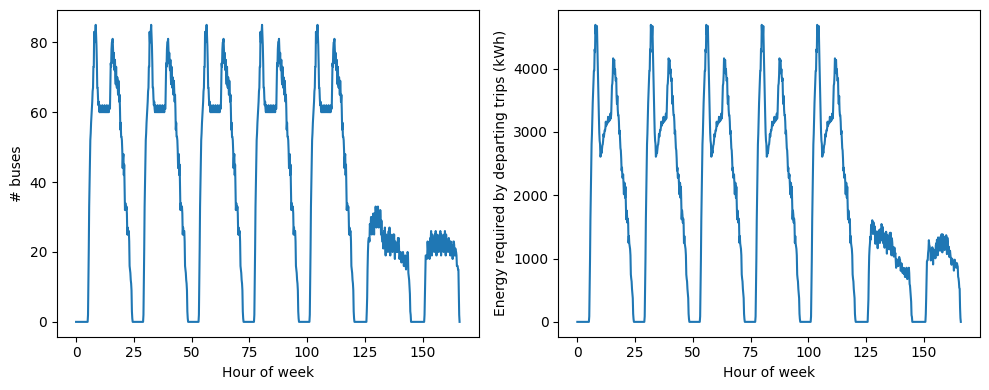

In [296]:

trips_data['passengers'] = 30

bus = ebus.Yutong()

# from RouteZero.bus import Bus as Ebus
# max_passengers = 70
# battery_capacity = 400      # kWh
# charging_rate = 200         # kW
# gross_mass = 18000          # kg

# # default parameters that they could optionally change
# charging_efficiency=0.9
# end_of_life_cap=0.8

# bus = Ebus(max_passengers, battery_capacity, charging_rate, gross_mass,
#               charging_efficiency=charging_efficiency, end_of_life_cap=end_of_life_cap)

prediction_pipe = PredictionPipe()

ec_km, ec_total = prediction_pipe.predict_worst_case(trips_data, bus)

times, buses_in_traffic, depart_trip_energy_reqs, return_trip_enery_consumed = calc_buses_in_traffic(trips_data,
                                                                                                     deadhead=DEADHEAD,
                                                                                                     resolution=RESOLUTION,
                                                                                                     trip_ec=ec_total)
t = np.cumsum(depart_trip_energy_reqs) - np.cumsum(return_trip_enery_consumed)
print("min requried buses = ", buses_in_traffic.max())

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(times / 60, buses_in_traffic)
plt.xlabel('Hour of week')
plt.ylabel('# buses')

plt.subplot(1, 2, 2)
# plt.plot(times / 60, depart_trip_energy_reqs)
plt.plot(times/60, t)
# plt.plot(times/60, return_trip_enery_consumed, label="returning trips")
plt.xlabel("Hour of week")
plt.ylabel("Energy required by departing trips (kWh)")

plt.tight_layout()
# plt.show()



In [297]:
# 996/6
166/7

23.714285714285715

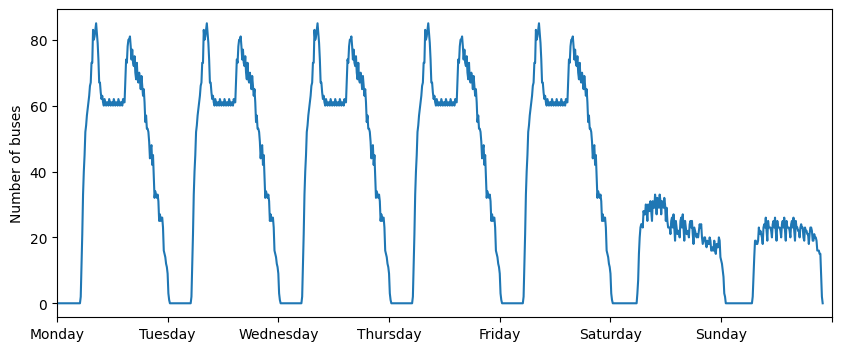

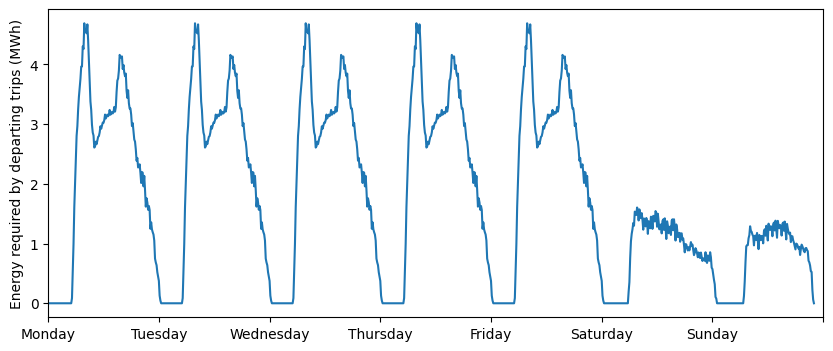

In [298]:

xticks = np.linspace(0,7*24,8)
xlabels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', '']

ax = plt.figure(figsize=(10, 4))
plt.subplot(1, 1, 1)
plt.plot(times / 60, buses_in_traffic)
# plt.xlabel('Day of week')
plt.ylabel('Number of buses')
plt.xticks(ticks=xticks, labels=xlabels)
plt.xlim([0, xticks[-1]])
plt.savefig('buses_in_traffic.pdf')
plt.savefig('buses_in_traffic.png')
# plt.close()

ax = plt.figure(figsize=(10, 4))
plt.subplot(1, 1, 1)
plt.plot(times/60, t/1000)
plt.ylabel("Energy required by departing trips (MWh)")
# plt.xlabel('Day of week')
plt.xticks(ticks=xticks, labels=xlabels)
plt.xlim([0, xticks[-1]])
plt.savefig('bus_energy.pdf')
plt.savefig('bus_energy.png')

In [299]:
# plot on map
route_summaries = summarise_results(trips_data, ec_km, ec_total)

gdf = _create_gdf_of_value(route_summaries, shapes, window='6:00 - 9:30')

map_title = "Route Energy Consumption"
colorbar_str = 'energy per km'

m = _create_gdf_map(gdf, map_title, colorbar_str)
_folium_open(m, map_title + '.html')

In [300]:
grid_limit = 'optim'
# grid_limit = 3500
Q = 10000    # relative cost on grid limit, set to 0 if no cost

Specify a priority on keeping the bus batteries charged at all times. Priority specified by R.

Note, this cost conflicts with the others as it attempts to maximise the battery charge (i.e. acts against other objectives). Hence the relative weighting of R with respect to the other weightings/costs will greatly impact the results and there will be a fine line between it doing nothing and overriding the other objectives.

In [301]:
R = 0       # priority on bus charge

Specify battery if we would like to include one. If we would like to optimise the battery capacity, then set to 'optim'. 'cost' is the relative weighting on the battery capacity. 'cost' must be provided either way.

If set to 'optim' attempts to minimise the capacity using the relative weighting of 'cost'

In [302]:
battery = {'power':2000, 'capacity':4000, 'efficiency':0.95, 'cost':10}
# battery = {'power':1000, 'capacity':'optim', 'efficiency':0.95, 'cost':100}
battery_specs = copy.deepcopy(battery)
no_battery = {'power':0, 'capacity':0, 'efficiency':0.95, 'cost':10}
no_battery_specs = copy.deepcopy(no_battery)

Chargers

In [303]:
charger_power_array = [80, 150, 300] 
charger_cost_array = [1, 5, 20]
chargers = {'power': charger_power_array, 
            'number': ["optim", "optim", "optim"], 
            'cost': charger_cost_array}
charger_specs = copy.deepcopy(chargers)

Specified allowed times of day to charge (which hours), default is all

In [304]:
all_times = [1]*7 + [1]*3 + [1]*5 + [1]*5 + [1]*4     # all times ok
off_peak = [1]*6 + [0]*4 + [1]*6 + [0]*7 + [1]*1     # peak times not allowed

Set up the problem and optimise

In [305]:
battery = copy.deepcopy(battery_specs)
problem = General_problem(trips_data, ec_total, bus, chargers, grid_limit=grid_limit, Q=Q, R=R, 
                          start_charge=START_CHARGE, final_charge=FINAL_CHARGE, deadhead=DEADHEAD,
                          resolution=RESOLUTION, min_charge_time=MIN_CHARGE_TIME, 
                          reserve=RESERVE, battery=battery, windows=all_times)

t1 = time.time()
results = problem.solve()
t2 = time.time()

print('Solve took {} seconds'.format(t2 - t1))

Solve took 62.584635972976685 seconds


Plot results

Max grid power is 2626.1971 kW
Optimised charger configuration is: 
{'power': [300, 150, 80], 'number': array([12.,  0.,  0.]), 'cost': [20, 5, 1]}
{'power': 2000, 'capacity': 4000, 'efficiency': 0.95, 'cost': 10}
Unable to achieve desired final charge by 0.0 %


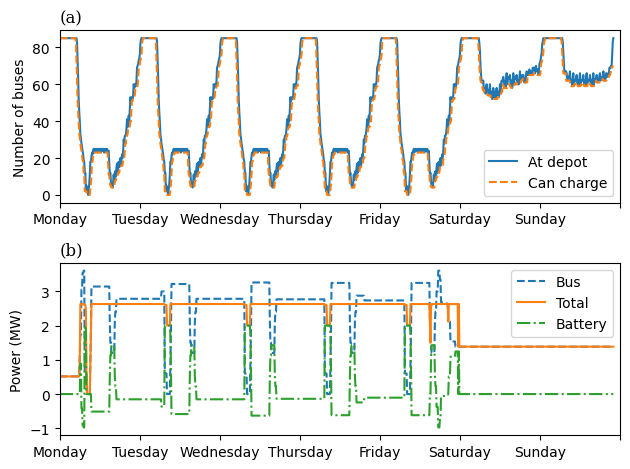

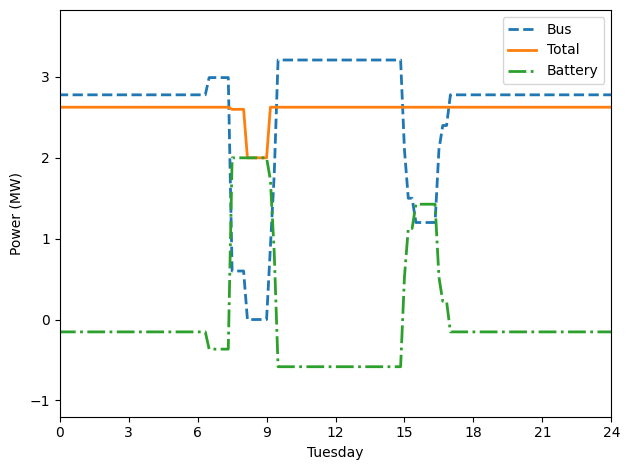

In [306]:
chargers_results = results['chargers']
charging_power = results['charging_power']
total_energy_avail = results['total_energy_available']
battery_soc = results['battery_soc']
aggregate_power = results['aggregate_power']
battery_power = results['battery_action']
times = problem.times

print('Max grid power is {} kW'.format(results['grid_limit']))
print('Optimised charger configuration is: ')
print(chargers_results)
print(results["battery_spec"])
print('Unable to achieve desired final charge by {} %'.format(results['final_soc_infeas_%']))

plot_results_paper(results, problem, 'all_times-battery')

all_times_battery = copy.deepcopy(aggregate_power)

In [307]:
# plot_study_results(results, problem)

Reference case without depot battery, leaving everything else the same

Solve took 40.10771465301514 seconds
Max grid power is 3101.0055 kW
Optimised charger configuration is: 
{'power': [300, 150, 80], 'number': array([10.,  1.,  0.]), 'cost': [20, 5, 1]}
{'power': 0, 'capacity': 0, 'efficiency': 0.95, 'cost': 10}
Unable to achieve desired final charge by 0.0 %


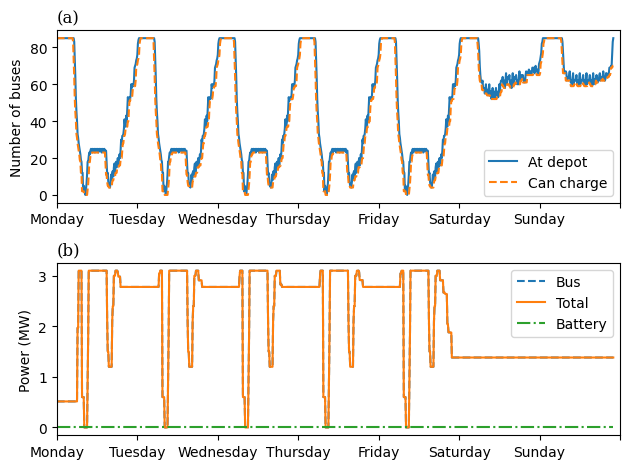

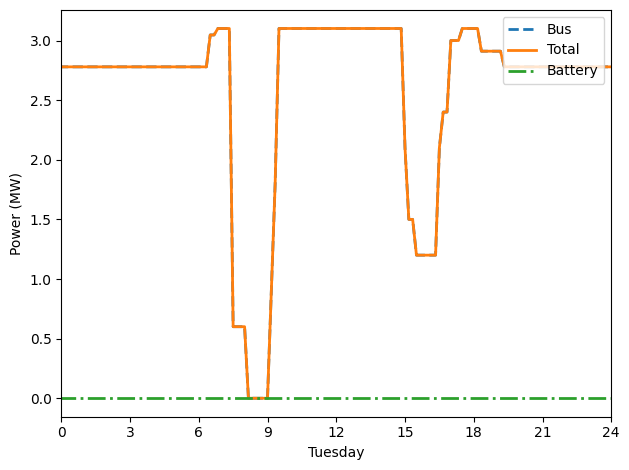

In [308]:

battery = copy.deepcopy(no_battery_specs)
chargers = copy.deepcopy(charger_specs)

problem = General_problem(trips_data, ec_total, bus, chargers, grid_limit=grid_limit, Q=Q, R=R, 
                          start_charge=START_CHARGE, final_charge=FINAL_CHARGE, deadhead=DEADHEAD,
                          resolution=RESOLUTION, min_charge_time=MIN_CHARGE_TIME, 
                          reserve=RESERVE, battery=battery, windows=all_times)

t1 = time.time()
results = problem.solve()
t2 = time.time()

print('Solve took {} seconds'.format(t2 - t1))

chargers_results = results['chargers']
charging_power = results['charging_power']
total_energy_avail = results['total_energy_available']
battery_soc = results['battery_soc']
aggregate_power = results['aggregate_power']
battery_power = results['battery_action']
times = problem.times

print('Max grid power is {} kW'.format(results['grid_limit']))
print('Optimised charger configuration is: ')
print(chargers_results)
print(results["battery_spec"])
print('Unable to achieve desired final charge by {} %'.format(results['final_soc_infeas_%']))

plot_results_paper(results, problem)
all_times_no_battery = copy.deepcopy(aggregate_power)

Reference case, no battery, off peak only charging

Solve took 15.522144079208374 seconds
Max grid power is 6900.0 kW
Optimised charger configuration is: 
{'power': [300, 150, 80], 'number': array([23.,  0.,  0.]), 'cost': [20, 5, 1]}
{'power': 0, 'capacity': 0, 'efficiency': 0.95, 'cost': 10}
Unable to achieve desired final charge by 16.287003415110117 %


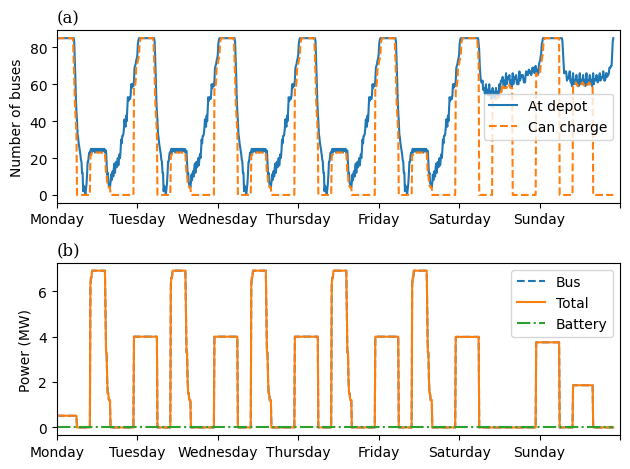

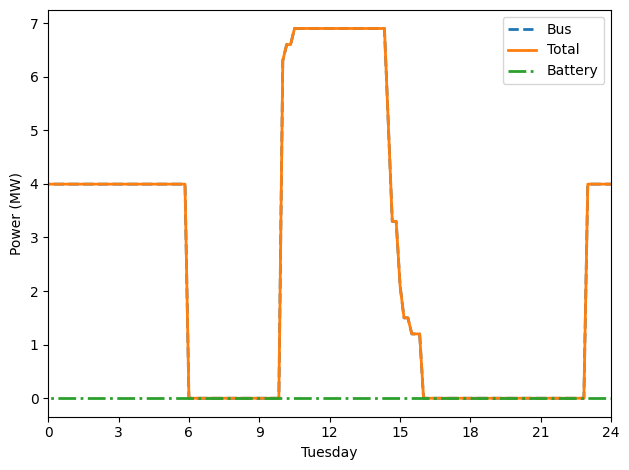

In [309]:
battery = copy.deepcopy(no_battery_specs)
chargers = copy.deepcopy(charger_specs)

problem = General_problem(trips_data, ec_total, bus, chargers, grid_limit=grid_limit, Q=Q, R=R, 
                          start_charge=START_CHARGE, final_charge=FINAL_CHARGE, deadhead=DEADHEAD,
                          resolution=RESOLUTION, min_charge_time=MIN_CHARGE_TIME, 
                          reserve=RESERVE, battery=battery, windows=off_peak)

t1 = time.time()
results = problem.solve()
t2 = time.time()

print('Solve took {} seconds'.format(t2 - t1))

chargers_results = results['chargers']
charging_power = results['charging_power']
total_energy_avail = results['total_energy_available']
battery_soc = results['battery_soc']
aggregate_power = results['aggregate_power']
battery_power = results['battery_action']
times = problem.times

print('Max grid power is {} kW'.format(results['grid_limit']))
print('Optimised charger configuration is: ')
print(chargers_results)
print(results["battery_spec"])
print('Unable to achieve desired final charge by {} %'.format(results['final_soc_infeas_%']))


plot_results_paper(results, problem)
off_peak_no_battery = copy.deepcopy(aggregate_power)

Reference case, battery, off peak

Solve took 32.82708692550659 seconds
Max grid power is 6011.1111 kW
Optimised charger configuration is: 
{'power': [300, 150, 80], 'number': array([23.,  0.,  0.]), 'cost': [20, 5, 1]}
{'power': 2000, 'capacity': 4000, 'efficiency': 0.95, 'cost': 10}
Unable to achieve desired final charge by 16.287003415110117 %


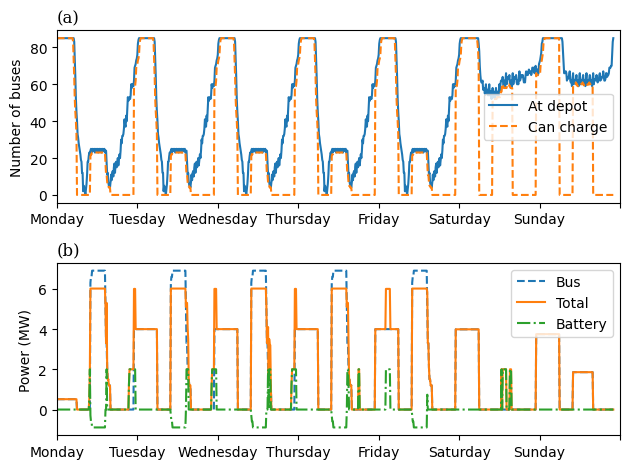

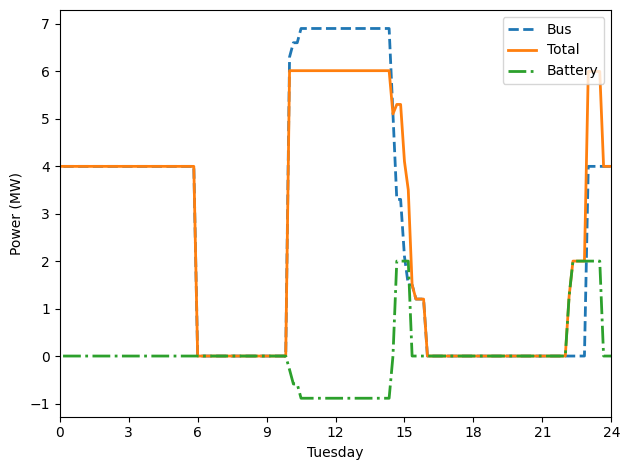

In [310]:
battery = copy.deepcopy(battery_specs)
chargers = copy.deepcopy(charger_specs)

problem = General_problem(trips_data, ec_total, bus, chargers, grid_limit=grid_limit, Q=Q, R=R, 
                          start_charge=START_CHARGE, final_charge=FINAL_CHARGE, deadhead=DEADHEAD,
                          resolution=RESOLUTION, min_charge_time=MIN_CHARGE_TIME, 
                          reserve=RESERVE, battery=battery, windows=off_peak)

t1 = time.time()
results = problem.solve()
t2 = time.time()

print('Solve took {} seconds'.format(t2 - t1))

chargers_results = results['chargers']
charging_power = results['charging_power']
total_energy_avail = results['total_energy_available']
battery_soc = results['battery_soc']
aggregate_power = results['aggregate_power']
battery_power = results['battery_action']
times = problem.times

print('Max grid power is {} kW'.format(results['grid_limit']))
print('Optimised charger configuration is: ')
print(chargers_results)
print(results["battery_spec"])
print('Unable to achieve desired final charge by {} %'.format(results['final_soc_infeas_%']))


plot_results_paper(results, problem)
off_peak_battery = copy.deepcopy(aggregate_power)

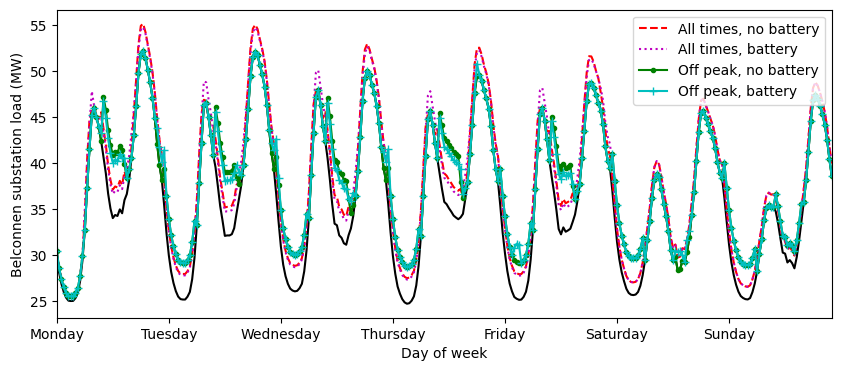

In [294]:
substation = pd.read_csv('Belconnen_substation_winter_average_week.csv')
substation.set_axis(pd.period_range(start='1/1/1991', periods=len(substation), freq="15T"), inplace=True)

simo_index = pd.period_range(start='1/1/1991', periods=len(off_peak_battery), freq="10T")
off_peak_no_battery_Series = pd.Series(index=simo_index, data=off_peak_no_battery).resample('30T').mean()
off_peak_battery_Series = pd.Series(index=simo_index, data=off_peak_battery).resample('30T').mean()
all_times_battery_Series = pd.Series(index=simo_index, data=all_times_battery).resample('30T').mean()
all_times_no_battery_Series = pd.Series(index=simo_index, data=all_times_no_battery).resample('30T').mean()

substation = substation.resample('30T').mean()[:-3]
substation_with_off_peak_no_battery = substation['MW'] + off_peak_no_battery_Series/1000
substation_with_off_peak_battery = substation['MW'] + off_peak_battery_Series/1000
substation_with_all_times_battery = substation['MW'] + all_times_battery_Series/1000
substation_with_all_times_no_battery = substation['MW'] + all_times_no_battery_Series/1000

# substation_with_all_times_no_battery

x_data = np.arange(len(substation))
xticks = np.linspace(0,7*24*2,8)
xticks = np.linspace(0,7*24*2,8)
xlabels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', '']

# substation_with_off_peak_battery = substation

ax = plt.figure(figsize=(10, 4))
plt.subplot(1, 1, 1)
plt.plot(x_data, substation['MW'], 'k-')
plt.plot(x_data, substation_with_all_times_no_battery, 'r--', label='All times, no battery')
plt.plot(x_data, substation_with_all_times_battery, 'm:', label='All times, battery')
plt.plot(x_data, substation_with_off_peak_no_battery, 'g.-', label='Off peak, no battery')
plt.plot(x_data, substation_with_off_peak_battery, 'c-+', label='Off peak, battery')
plt.ylabel("Belconnen substation load (MW)")
plt.xlabel('Day of week')
plt.xticks(ticks=xticks, labels=xlabels)
plt.xlim([0, x_data[-1]])
plt.legend(loc='upper right')
plt.savefig('substation.pdf')
plt.savefig('substation.png')


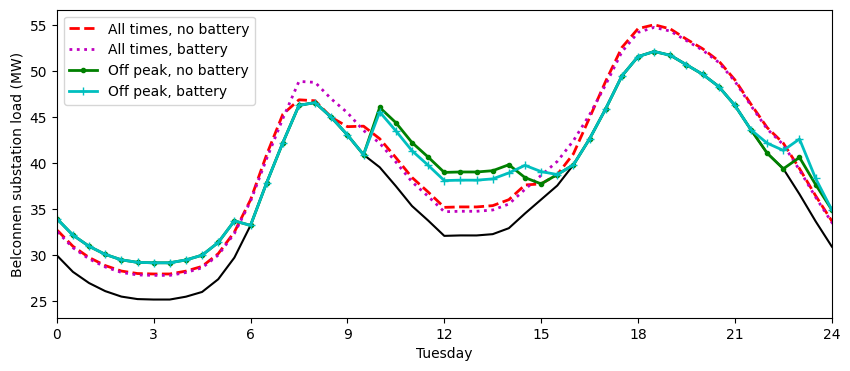

In [203]:
tue_start = 24*2
tue_end = 24*4
xticks = tue_start + np.array([0,3,6,9,12,15,18,21,24])*2
xlabels = ['0','3','6','9','12','15','18','21','24']

ax1 = plt.figure(figsize=(10, 4))
plt.subplot(1, 1, 1)
plt.plot(x_data, substation['MW'], 'k-')
plt.plot(x_data, substation_with_all_times_no_battery, 'r--', label='All times, no battery',linewidth=2)
plt.plot(x_data, substation_with_all_times_battery, 'm:', label='All times, battery',linewidth=2)
plt.plot(x_data, substation_with_off_peak_no_battery, 'g.-', label='Off peak, no battery',linewidth=2)
plt.plot(x_data, substation_with_off_peak_battery, 'c-+', label='Off peak, battery',linewidth=2)
plt.ylabel("Belconnen substation load (MW)")
plt.xlabel('Tuesday')
plt.xticks(ticks=xticks, labels=xlabels)
plt.xlim([tue_start, tue_end])
# plt.legend(loc='lower center')
plt.legend(loc='upper left')
plt.savefig('substation-zoom.pdf')
plt.savefig('substation-zoom.png')


### Now investigate the effects of extra buses, chargers and depot batteries on peak power demand

Scan number of buses, charging at all times

In [39]:
num_chargers_scans_300 = 12

In [210]:
nu_buses = 11
min_bus = 85
max_bus = 95


t1 = time.time()
scan_bus_peak_demands = []
scan_bus_chargers_required = []

Q = 10000
for num_bus in np.linspace(min_bus, max_bus, nu_buses):
    chargers = {'power': charger_power_array, 
            'number': ["optim", "optim", "optim"], 
            'cost': charger_cost_array}

    problem = General_problem(trips_data, ec_total, bus, chargers, grid_limit=grid_limit, Q=Q, R=R, 
                          start_charge=START_CHARGE, final_charge=FINAL_CHARGE, deadhead=DEADHEAD,
                          resolution=RESOLUTION, min_charge_time=MIN_CHARGE_TIME, 
                          reserve=RESERVE, battery=battery, num_buses=num_bus,
                          windows=all_times)
    
    results = problem.solve()
    
    scan_bus_peak_demands.append(results['grid_limit'])
    scan_bus_chargers_required.append(chargers['number'])

print(scan_bus_peak_demands)
print(scan_bus_chargers_required)
t2 = time.time()
print('Solve took {} seconds'.format(t2 - t1))

[2626.1971, 2592.1435, 2568.5075, 2555.8925, 2544.5433, 2534.1959, 2528.6276, 2524.4767, 2520.7075, 2517.7496, 2515.3266]
[array([12.,  0.,  0.]), array([13.,  0.,  0.]), array([14.,  0.,  0.]), array([15.,  0.,  0.]), array([14.,  1.,  1.]), array([13.,  3.,  1.]), array([ 8.,  1., 12.]), array([8., 1., 5.]), array([8., 0., 3.]), array([8., 1., 1.]), array([7., 3., 0.])]
Solve took 1128.1948912143707 seconds


Scan number of buses, charging outside peak times

In [211]:


t1 = time.time()
scan_bus_peak_demands_offpeak = []
scan_bus_chargers_required_offpeak = []
Q = 10000
for num_bus in np.linspace(min_bus, max_bus, nu_buses):
    chargers = {'power': charger_power_array, 
                'number': ["optim", "optim", "optim"], 
                'cost': charger_cost_array}

    problem = General_problem(trips_data, ec_total, bus, chargers, grid_limit=grid_limit, Q=Q, R=R, 
                          start_charge=START_CHARGE, final_charge=FINAL_CHARGE, deadhead=DEADHEAD,
                          resolution=RESOLUTION, min_charge_time=MIN_CHARGE_TIME, 
                          reserve=RESERVE, battery=battery, num_buses=num_bus,
                          windows=off_peak)
    
    results = problem.solve()
    
    scan_bus_peak_demands_offpeak.append(results['grid_limit'])
    scan_bus_chargers_required_offpeak.append(chargers['number'])

print(scan_bus_peak_demands_offpeak)
print(scan_bus_chargers_required_offpeak)
t2 = time.time()
print('Solve took {} seconds'.format(t2 - t1))

[6011.1111, 6168.4254, 6157.2738, 6123.9404, 6098.0854, 6068.2623, 6036.1194, 5991.7532, 5848.9262, 5725.6925, 5612.3872]
[array([23.,  0.,  0.]), array([23.,  2.,  0.]), array([22.,  4.,  0.]), array([21.,  6.,  0.]), array([20.,  7.,  1.]), array([19., 10.,  1.]), array([18., 12.,  1.]), array([18.,  7.,  6.]), array([19.,  1., 12.]), array([19.,  0., 11.]), array([17.,  3., 12.])]
Solve took 402.36258816719055 seconds


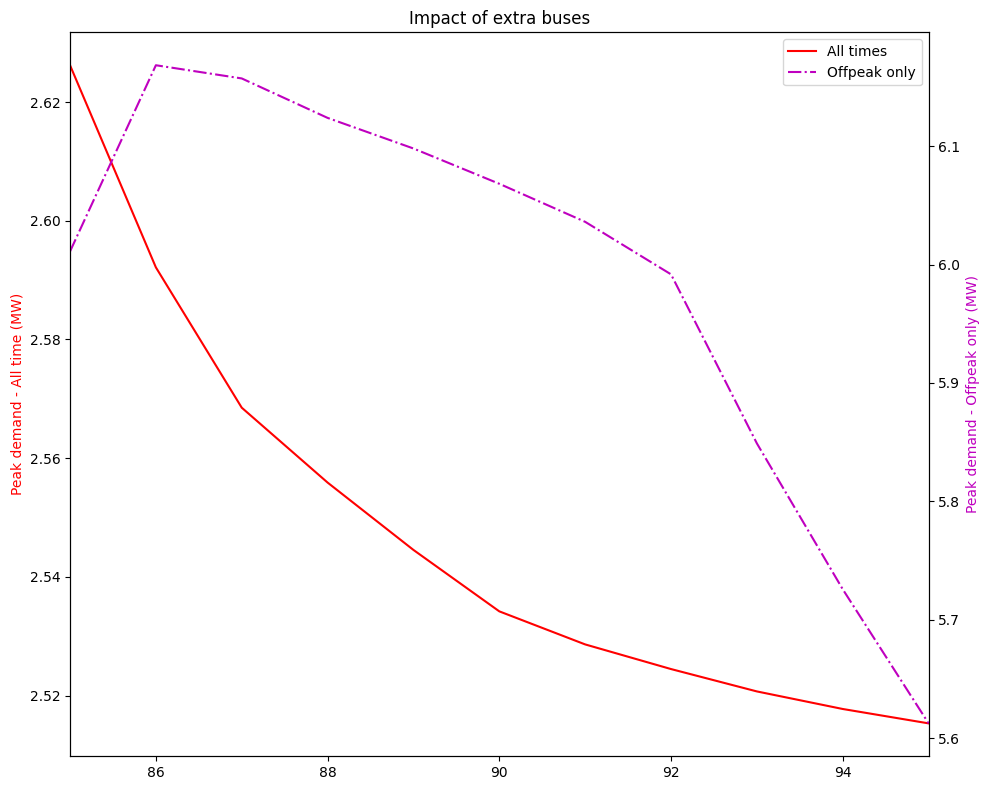

In [212]:
x_data = np.linspace(min_bus,max_bus,nu_buses)
plt.figure(figsize=(10, 8))
ax1 = plt.subplot(1, 1, 1)
lns1 = ax1.plot(x_data, np.array(scan_bus_peak_demands)/1000, 'r', label='All times')
ax2 = ax1.twinx()
lns2 = ax2.plot(x_data, np.array(scan_bus_peak_demands_offpeak)/1000, 'm', label='Offpeak only', linestyle='-.')
# plt.axhline(grid_limit, linestyle='--', color='r', label='peak grid power')
plt.title('Impact of extra buses')
plt.xlabel('Number of buses')
ax1.set_ylabel('Peak demand - All time (MW)', color='r')
ax2.set_ylabel('Peak demand - Offpeak only (MW)', color='m')
plt.xlim([x_data[0], x_data[-1]])
# added these three lines
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

plt.tight_layout()
plt.show()

In [43]:
num_buses_scans = 85 + 2

Scan number of chargers, charging at all times

In [44]:
nu_chargers = 9
min_charger = 12
max_charger = 20

t1 = time.time()
scan_charger_peak_demands = []
scan_charger_chargers_required = []
Q = 10000
for c in np.linspace(min_charger,max_charger,nu_chargers):
    chargers = {'power': charger_power_array, 
                'number': ["optim", "optim", int(c)], 
                'cost': charger_cost_array}

    problem = General_problem(trips_data, ec_total, bus, chargers, grid_limit=grid_limit, Q=Q, R=R, 
                          start_charge=START_CHARGE, final_charge=FINAL_CHARGE, deadhead=DEADHEAD,
                          resolution=RESOLUTION, min_charge_time=MIN_CHARGE_TIME, 
                          reserve=RESERVE, battery=battery, num_buses=num_buses_scans,
                          windows=all_times)
    
    results = problem.solve()
    
    scan_charger_peak_demands.append(results['grid_limit'])
    scan_charger_chargers_required.append(chargers['number'])

print(scan_charger_peak_demands)
print(scan_charger_chargers_required)
t2 = time.time()
print('Solve took {} seconds'.format(t2 - t1))

[2569.4547, 2568.9811, 2568.5075, 2568.5075, 2568.5075, 2568.5075, 2568.5075, 2568.5075, 2568.5075]
[array([12.,  2.,  0.]), array([13.,  1.,  0.]), array([14.,  0.,  0.]), array([15.,  0.,  0.]), array([16.,  0.,  0.]), array([17.,  0.,  0.]), array([18.,  0.,  0.]), array([19.,  0.,  0.]), array([20.,  0.,  0.])]
Solve took 598.275470495224 seconds


Scan number of chargers, charging outside peak times

In [45]:

t1 = time.time()
scan_charger_peak_demands_offpeak = []
scan_charger_chargers_required_offpeak = []
Q = 10000
for c in np.linspace(min_charger,max_charger,nu_chargers):
    chargers = {'power': charger_power_array, 
                'number': ["optim", "optim", int(c)], 
                'cost': charger_cost_array}

    problem = General_problem(trips_data, ec_total, bus, chargers, grid_limit=grid_limit, Q=Q, R=R, 
                          start_charge=START_CHARGE, final_charge=FINAL_CHARGE, deadhead=DEADHEAD,
                          resolution=RESOLUTION, min_charge_time=MIN_CHARGE_TIME, 
                          reserve=RESERVE, battery=battery, num_buses=num_buses_scans,
                          windows=off_peak)
    
    results = problem.solve()
    
    scan_charger_peak_demands_offpeak.append(results['grid_limit'])
    scan_charger_chargers_required_offpeak.append(chargers['number'])

print(scan_charger_peak_demands_offpeak)
print(scan_charger_chargers_required_offpeak)
t2 = time.time()
print('Solve took {} seconds'.format(t2 - t1))

[4683.3333, 4833.3333, 4983.3333, 5133.3333, 5283.3333, 5433.3333, 5583.3333, 5733.3333, 5883.3333]
[array([12., 13.,  0.]), array([13., 12.,  0.]), array([14., 11.,  0.]), array([15., 10.,  0.]), array([16.,  9.,  0.]), array([17.,  8.,  0.]), array([18.,  7.,  0.]), array([19.,  6.,  0.]), array([20.,  5.,  0.])]
Solve took 284.98580026626587 seconds


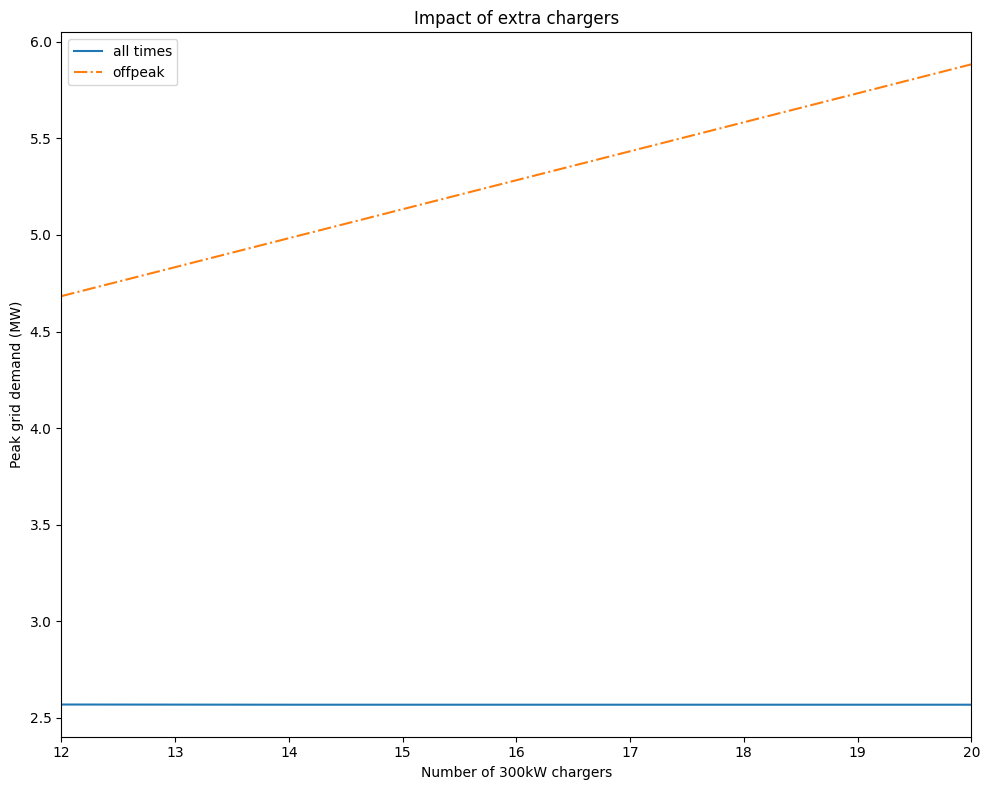

In [46]:
x_data = np.linspace(min_charger,max_charger,nu_chargers)
plt.figure(figsize=(10, 8))
plt.subplot(1, 1, 1)
plt.plot(x_data, np.array(scan_charger_peak_demands)/1000, label='all times')
plt.plot(x_data, np.array(scan_charger_peak_demands_offpeak)/1000, label='offpeak', linestyle='-.')
# plt.axhline(grid_limit, linestyle='--', color='r', label='peak grid power')
plt.title('Impact of extra chargers')
plt.xlabel('Number of 300kW chargers')
plt.ylabel('Peak grid demand (MW)')
plt.xlim([x_data[0], x_data[-1]])
plt.legend()

plt.tight_layout()
plt.show()

Scan battery capacities, charging at all times

In [47]:
nu_batteries = 9
min_battery = 0
max_battery = 4


t1 = time.time()
scan_battery_peak_demands = []
scan_battery_chargers_required = []
Q = 10000
batt_c_rating = 2
for batt_p in np.linspace(min_battery,max_battery,nu_batteries):
    chargers = {'power': charger_power_array, 
                'number': ["optim", "optim", "optim"], 
                'cost': charger_cost_array}
    
    battery = {'power':batt_p, 'capacity':batt_p*batt_c_rating, 'efficiency':0.95, 'cost':10}

    problem = General_problem(trips_data, ec_total, bus, chargers, grid_limit=grid_limit, Q=Q, R=R, 
                          start_charge=START_CHARGE, final_charge=FINAL_CHARGE, deadhead=DEADHEAD,
                          resolution=RESOLUTION, min_charge_time=MIN_CHARGE_TIME, 
                          reserve=RESERVE, battery=battery, num_buses=num_buses_scans,
                          windows=all_times)
    
    results = problem.solve()
    
    scan_battery_peak_demands.append(results['grid_limit'])
    scan_battery_chargers_required.append(chargers['number'])

print(scan_battery_peak_demands)
print(scan_battery_chargers_required)
t2 = time.time()
print('Solve took {} seconds'.format(t2 - t1))

[2787.5573, 2787.4598, 2787.3624, 2787.2649, 2787.1674, 2787.07, 2786.9725, 2786.8751, 2786.7776]
[array([9., 1., 0.]), array([9., 1., 0.]), array([9., 1., 0.]), array([9., 1., 0.]), array([9., 1., 0.]), array([9., 1., 0.]), array([9., 1., 0.]), array([9., 1., 0.]), array([9., 1., 0.])]
Solve took 583.3234252929688 seconds


Scan battery capacities, charging outside peak times

In [48]:

t1 = time.time()
scan_battery_peak_demands_offpeak = []
chargers_required_offpeak = []
Q = 10000
batt_c_rating = 2
for batt_p in np.linspace(min_battery,max_battery,nu_batteries):
    chargers = {'power': charger_power_array, 
                'number': ["optim", "optim", "optim"], 
                'cost': charger_cost_array}
    
    battery = {'power':batt_p, 'capacity':batt_p*batt_c_rating, 'efficiency':0.95, 'cost':10}

    problem = General_problem(trips_data, ec_total, bus, chargers, grid_limit=grid_limit, Q=Q, R=R, 
                          start_charge=START_CHARGE, final_charge=FINAL_CHARGE, deadhead=DEADHEAD,
                          resolution=RESOLUTION, min_charge_time=MIN_CHARGE_TIME, 
                          reserve=RESERVE, battery=battery, num_buses=num_buses_scans,
                          windows=off_peak)
    
    results = problem.solve()
    
    scan_battery_peak_demands_offpeak.append(results['grid_limit'])
    chargers_required_offpeak.append(chargers['number'])

print(scan_battery_peak_demands_offpeak)
print(chargers_required_offpeak)
t2 = time.time()
print('Solve took {} seconds'.format(t2 - t1))

[7005.6305, 7005.4112, 7005.192, 7004.9728, 7004.7535, 7004.5343, 7004.3151, 7004.0959, 7003.8766]
[array([23.,  1.,  1.]), array([23.,  1.,  1.]), array([23.,  1.,  1.]), array([23.,  1.,  1.]), array([23.,  1.,  1.]), array([23.,  1.,  1.]), array([23.,  1.,  0.]), array([23.,  1.,  1.]), array([23.,  1.,  1.])]
Solve took 258.03787636756897 seconds


In [204]:
x_data = np.linspace(min_battery/1000,max_battery/1000,nu_batteries)
plt.figure(figsize=(10, 8))
plt.subplot(1, 1, 1)
plt.plot(x_data, np.array(scan_battery_peak_demands)/1000, label='all times')
plt.plot(x_data, np.array(scan_battery_peak_demands_offpeak)/1000, label='offpeak', linestyle='-.')
# plt.axhline(grid_limit, linestyle='--', color='r', label='peak grid power')
plt.title('Impact of depot battery')
plt.xlabel('Battery power capacity (MW)')
plt.ylabel('Peak grid demand (MW)')
plt.xlim([x_data[0], x_data[-1]])
plt.legend()

plt.tight_layout()
plt.show()



NameError: name 'min_battery' is not defined

In [50]:
nu_battery_powers = 11
min_battery_p = 0
max_battery_p = 5 #MW
batt_ps = np.linspace(min_battery_p,max_battery_p,nu_battery_powers)
nu_battery_capacities = 21
min_battery_c = 0
max_battery_c = 10 #MWh
batt_cs = np.linspace(min_battery_c,max_battery_c,nu_battery_capacities)

t1 = time.time()
scan_battery_peak_demands = pd.DataFrame(index=batt_ps, columns=batt_cs, data = np.zeros([nu_battery_powers,nu_battery_capacities]))
scan_battery_chargers_required_300 = pd.DataFrame(index=batt_ps, columns=batt_cs, data = np.zeros([nu_battery_powers,nu_battery_capacities]))
scan_battery_chargers_required_150 = pd.DataFrame(index=batt_ps, columns=batt_cs, data = np.zeros([nu_battery_powers,nu_battery_capacities]))
scan_battery_chargers_required_80 = pd.DataFrame(index=batt_ps, columns=batt_cs, data = np.zeros([nu_battery_powers,nu_battery_capacities]))
Q = 10000
for batt_p in batt_ps:
    for batt_c in batt_cs:
        chargers = {'power': charger_power_array, 
                    'number': ["optim", "optim", "optim"], 
                    'cost': charger_cost_array}
        
        battery = {'power':batt_p*1000, 'capacity':batt_c*1000, 'efficiency':0.95, 'cost':10}

        problem = General_problem(trips_data, ec_total, bus, chargers, grid_limit=grid_limit, Q=Q, R=R, 
                            start_charge=START_CHARGE, final_charge=FINAL_CHARGE, deadhead=DEADHEAD,
                            resolution=RESOLUTION, min_charge_time=MIN_CHARGE_TIME, 
                            reserve=RESERVE, battery=battery, num_buses=num_buses_scans,
                            windows=all_times)
        
        results = problem.solve()
        
        scan_battery_peak_demands.loc[batt_p, batt_c] = float(results['grid_limit'])
        scan_battery_chargers_required_80.loc[batt_p, batt_c] = float(chargers['number'][0])
        scan_battery_chargers_required_150.loc[batt_p, batt_c] = float(chargers['number'][1])
        scan_battery_chargers_required_300.loc[batt_p, batt_c] = float(chargers['number'][2])

print(scan_battery_peak_demands)
print(scan_battery_chargers_required)
t2 = time.time()
print('Solve took {} seconds'.format(t2 - t1))

          0.0        0.5        1.0        1.5        2.0        2.5   \
0.0  2787.5573  2787.5573  2787.5573  2787.5573  2787.5573  2787.5573   
0.5  2787.5573  2730.2219  2700.2927  2695.1535  2690.0147  2684.8760   
1.0  2787.5573  2729.8225  2674.8421  2649.9395  2634.3271  2629.5429   
1.5  2787.5573  2729.8225  2673.0206  2648.2391  2624.1193  2600.0524   
2.0  2787.5573  2729.8225  2672.9220  2648.0625  2623.8621  2599.7137   
2.5  2787.5573  2729.8225  2672.9220  2648.0625  2623.8621  2599.7137   
3.0  2787.5573  2729.8225  2672.9220  2648.0625  2623.8621  2599.7137   
3.5  2787.5573  2729.8225  2672.9220  2648.0625  2623.8621  2599.7137   
4.0  2787.5573  2729.8225  2672.9220  2648.0625  2623.8621  2599.7137   
4.5  2787.5573  2729.8225  2672.9220  2648.0625  2623.8621  2599.7137   
5.0  2787.5573  2729.8225  2672.9220  2648.0625  2623.8621  2599.7137   

          3.0        3.5        4.0        4.5   ...       5.5        6.0   \
0.0  2787.5573  2787.5573  2787.5573  2787.55

Text(0, 0.5, 'Number of 300kW chargers')

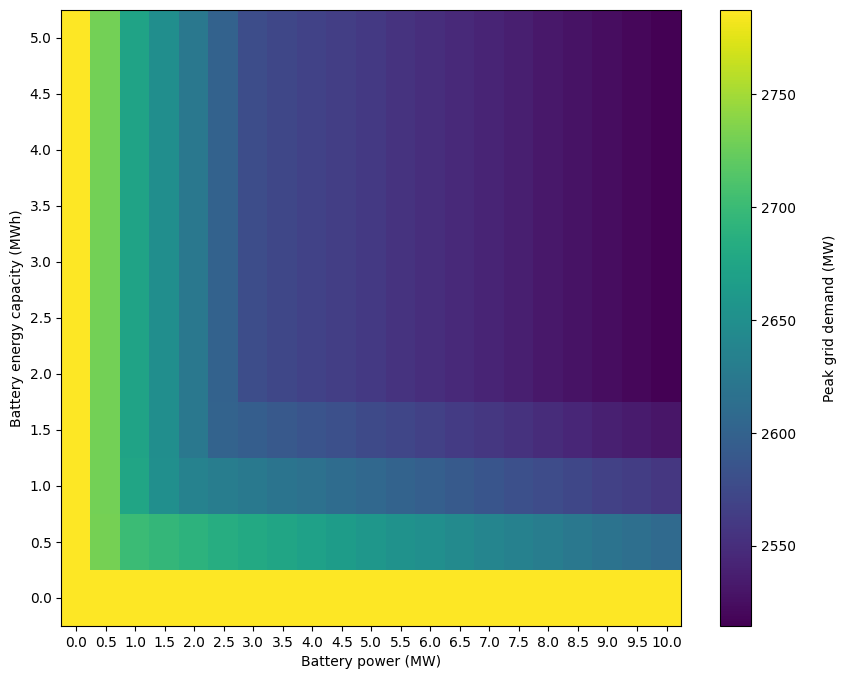

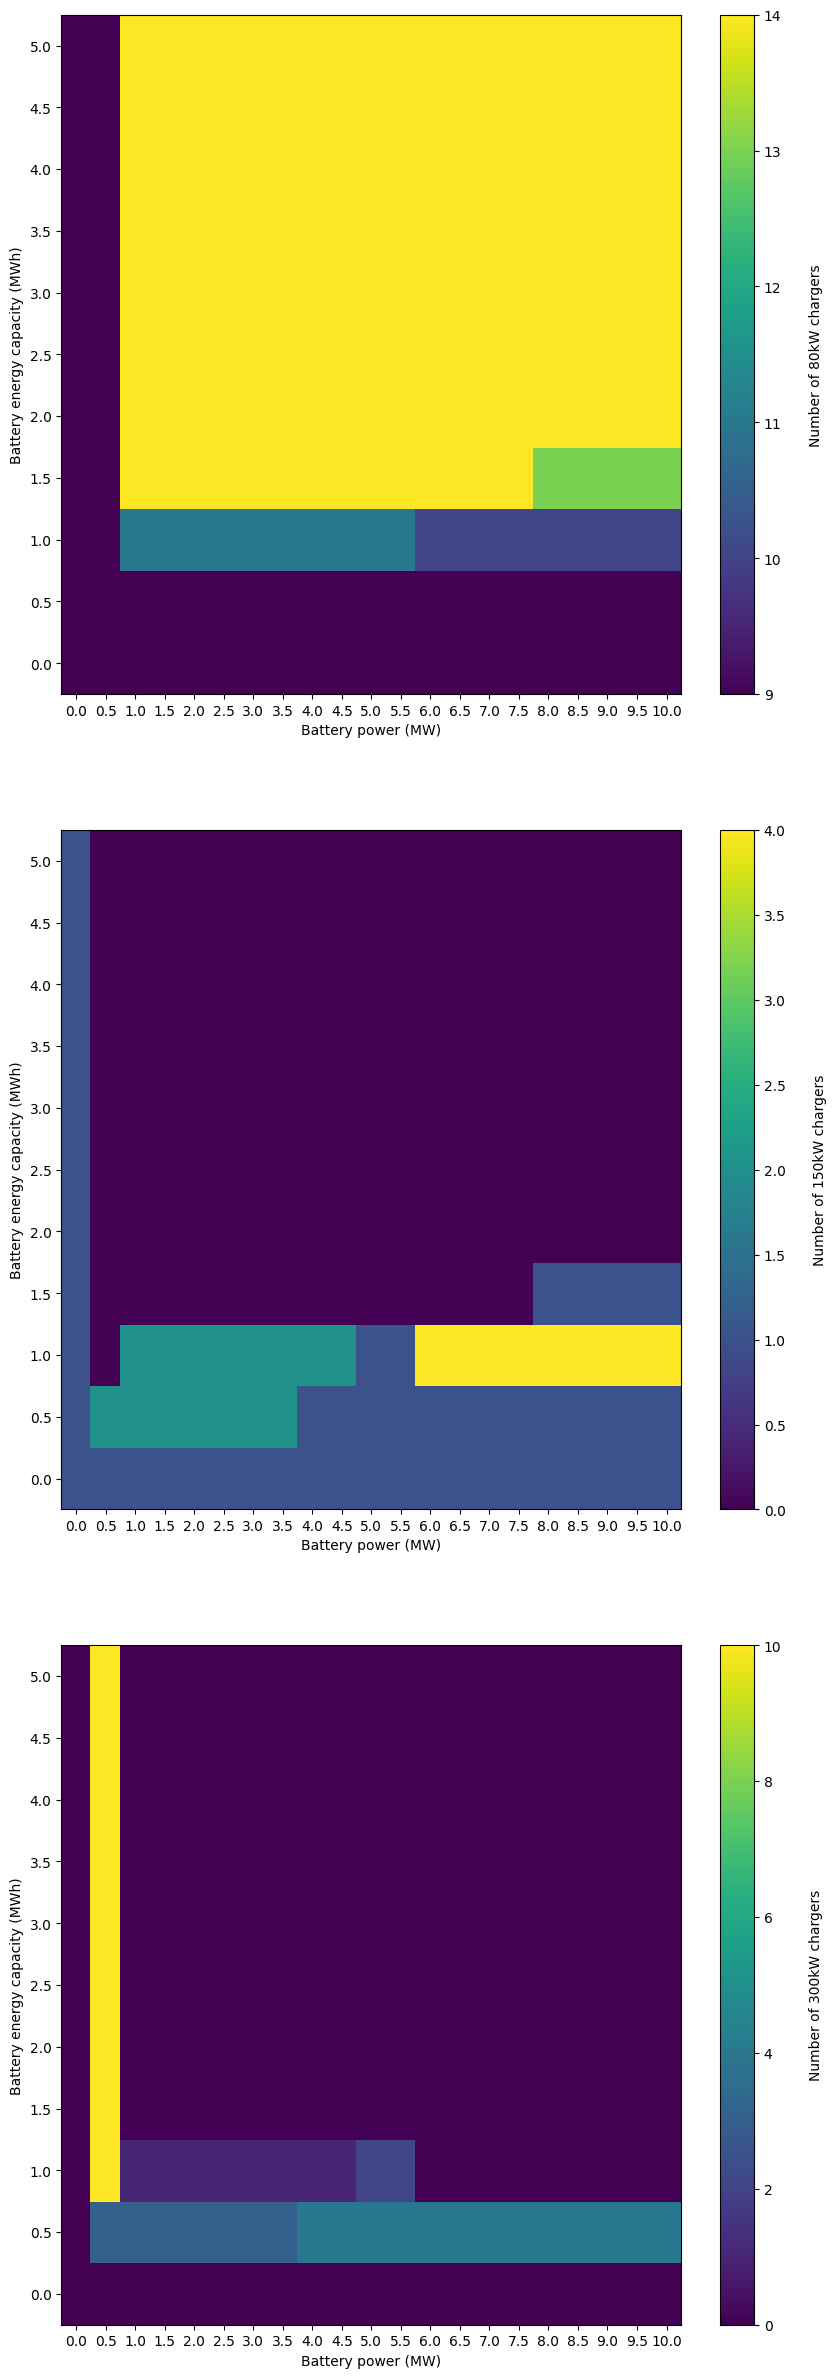

In [51]:
fig = plt.figure(figsize=(10, 8))
plt.subplot(1, 1, 1)
im = plt.pcolor(scan_battery_peak_demands)
plt.yticks(np.arange(0.5, len(scan_battery_peak_demands.index), 1), scan_battery_peak_demands.index)
plt.xticks(np.arange(0.5, len(scan_battery_peak_demands.columns), 1), scan_battery_peak_demands.columns)
plt.ylabel("Battery power (MW)")
plt.xlabel("Battery energy capacity (MWh)")
cbar = fig.colorbar(im)
cbar.ax.set_ylabel(r"Peak grid demand (MW)", labelpad=20)#, rotation=270)
plt.savefig('battery_scan.png')
plt.savefig('battery_scan.pdf')

fig = plt.figure(figsize=(10, 30))
plt.subplot(3, 1, 1)
im = plt.pcolor(scan_battery_chargers_required_80)
plt.yticks(np.arange(0.5, len(scan_battery_chargers_required_80.index), 1), scan_battery_chargers_required_80.index)
plt.xticks(np.arange(0.5, len(scan_battery_chargers_required_80.columns), 1), scan_battery_chargers_required_80.columns)
plt.ylabel("Battery power (MW)")
plt.xlabel("Battery energy capacity (MWh)")
cbar = fig.colorbar(im)
cbar.ax.set_ylabel(r"Number of 80kW chargers", labelpad=20)#, rotation=270)
plt.subplot(3, 1, 2)
im = plt.pcolor(scan_battery_chargers_required_150)
plt.yticks(np.arange(0.5, len(scan_battery_chargers_required_150.index), 1), scan_battery_chargers_required_150.index)
plt.xticks(np.arange(0.5, len(scan_battery_chargers_required_150.columns), 1), scan_battery_chargers_required_150.columns)
plt.ylabel("Battery power (MW)")
plt.xlabel("Battery energy capacity (MWh)")
cbar = fig.colorbar(im)
cbar.ax.set_ylabel(r"Number of 150kW chargers", labelpad=20)#, rotation=270)
plt.subplot(3, 1, 3)
im = plt.pcolor(scan_battery_chargers_required_300)
plt.yticks(np.arange(0.5, len(scan_battery_chargers_required_300.index), 1), scan_battery_chargers_required_300.index)
plt.xticks(np.arange(0.5, len(scan_battery_chargers_required_300.columns), 1), scan_battery_chargers_required_300.columns)
plt.ylabel("Battery power (MW)")
plt.xlabel("Battery energy capacity (MWh)")
cbar = fig.colorbar(im)
cbar.ax.set_ylabel(r"Number of 300kW chargers", labelpad=20)#, rotation=270)

In [52]:

t1 = time.time()
scan_battery_peak_demands = pd.DataFrame(index=batt_ps, columns=batt_cs, data = np.zeros([nu_battery_powers,nu_battery_capacities]))
scan_battery_chargers_required_300 = pd.DataFrame(index=batt_ps, columns=batt_cs, data = np.zeros([nu_battery_powers,nu_battery_capacities]))
scan_battery_chargers_required_150 = pd.DataFrame(index=batt_ps, columns=batt_cs, data = np.zeros([nu_battery_powers,nu_battery_capacities]))
scan_battery_chargers_required_80 = pd.DataFrame(index=batt_ps, columns=batt_cs, data = np.zeros([nu_battery_powers,nu_battery_capacities]))
Q = 10000
for batt_p in batt_ps:
    for batt_c in batt_cs:
        chargers = {'power': charger_power_array, 
                    'number': ["optim", "optim", "optim"], 
                    'cost': charger_cost_array}
        
        battery = {'power':batt_p*1000, 'capacity':batt_c*1000, 'efficiency':0.95, 'cost':10}

        problem = General_problem(trips_data, ec_total, bus, chargers, grid_limit=grid_limit, Q=Q, R=R, 
                            start_charge=START_CHARGE, final_charge=FINAL_CHARGE, deadhead=DEADHEAD,
                            resolution=RESOLUTION, min_charge_time=MIN_CHARGE_TIME, 
                            reserve=RESERVE, battery=battery, num_buses=num_buses_scans,
                            windows=off_peak)
        
        results = problem.solve()
        
        scan_battery_peak_demands.loc[batt_p, batt_c] = float(results['grid_limit'])
        scan_battery_chargers_required_80.loc[batt_p, batt_c] = float(chargers['number'][0])
        scan_battery_chargers_required_150.loc[batt_p, batt_c] = float(chargers['number'][1])
        scan_battery_chargers_required_300.loc[batt_p, batt_c] = float(chargers['number'][2])

print(scan_battery_peak_demands)
print(scan_battery_chargers_required)
t2 = time.time()
print('Solve took {} seconds'.format(t2 - t1))

          0.0        0.5        1.0        1.5        2.0        2.5   \
0.0  7005.6305  7005.6305  7005.6305  7005.6305  7005.6305  7005.6305   
0.5  7005.6305  6896.1627  6790.6071  6685.0516  6579.4960  6505.6305   
1.0  7005.6305  6896.1627  6790.6071  6685.0516  6579.4960  6473.9404   
1.5  7005.6305  6896.1627  6790.6071  6685.0516  6579.4960  6473.9404   
2.0  7005.6305  6896.1627  6790.6071  6685.0516  6579.4960  6473.9404   
2.5  7005.6305  6896.1627  6790.6071  6685.0516  6579.4960  6473.9404   
3.0  7005.6305  6896.1627  6790.6071  6685.0516  6579.4960  6473.9404   
3.5  7005.6305  6896.1627  6790.6071  6685.0516  6579.4960  6473.9404   
4.0  7005.6305  6896.1627  6790.6071  6685.0516  6579.4960  6473.9404   
4.5  7005.6305  6896.1627  6790.6071  6685.0516  6579.4960  6473.9404   
5.0  7005.6305  6896.1627  6790.6071  6685.0516  6579.4960  6473.9404   

          3.0        3.5        4.0        4.5   ...       5.5        6.0   \
0.0  7005.6305  7005.6305  7005.6305  7005.63

Text(0, 0.5, 'Number of 300kW chargers')

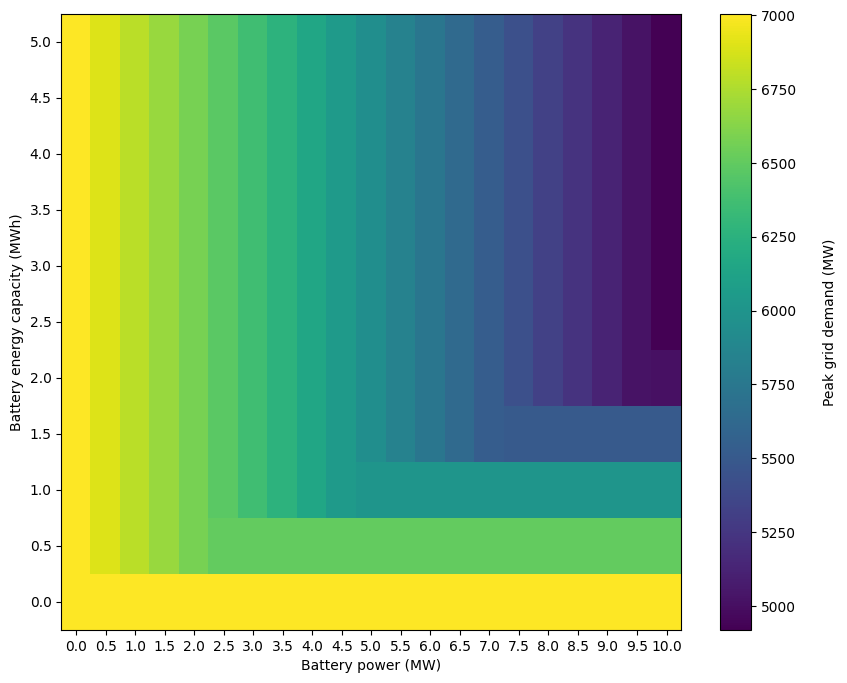

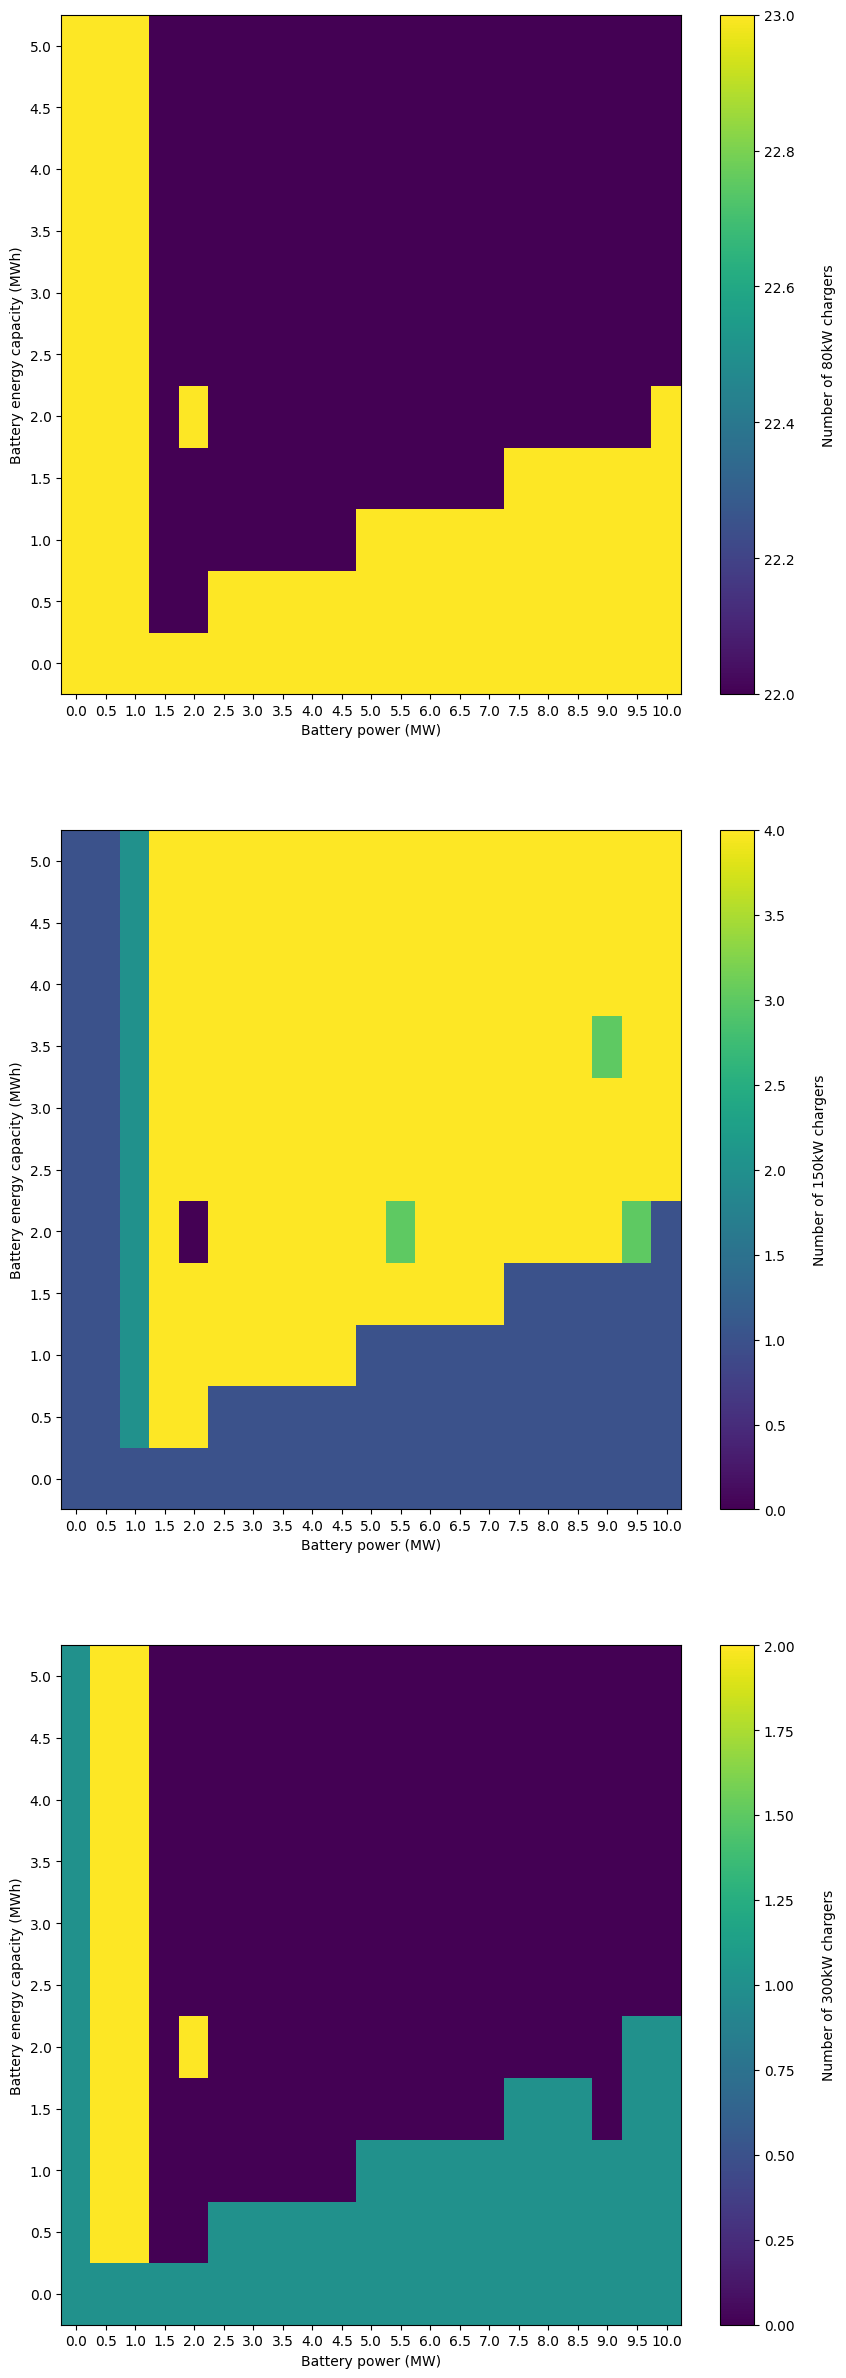

In [53]:
fig = plt.figure(figsize=(10, 8))
plt.subplot(1, 1, 1)
im = plt.pcolor(scan_battery_peak_demands)
plt.yticks(np.arange(0.5, len(scan_battery_peak_demands.index), 1), scan_battery_peak_demands.index)
plt.xticks(np.arange(0.5, len(scan_battery_peak_demands.columns), 1), scan_battery_peak_demands.columns)
plt.ylabel("Battery power (MW)")
plt.xlabel("Battery energy capacity (MWh)")
cbar = fig.colorbar(im)
cbar.ax.set_ylabel(r"Peak grid demand (MW)", labelpad=20)#, rotation=270)

fig = plt.figure(figsize=(10, 30))
plt.subplot(3, 1, 1)
im = plt.pcolor(scan_battery_chargers_required_80)
plt.yticks(np.arange(0.5, len(scan_battery_chargers_required_80.index), 1), scan_battery_chargers_required_80.index)
plt.xticks(np.arange(0.5, len(scan_battery_chargers_required_80.columns), 1), scan_battery_chargers_required_80.columns)
plt.ylabel("Battery power (MW)")
plt.xlabel("Battery energy capacity (MWh)")
cbar = fig.colorbar(im)
cbar.ax.set_ylabel(r"Number of 80kW chargers", labelpad=20)#, rotation=270)
plt.subplot(3, 1, 2)
im = plt.pcolor(scan_battery_chargers_required_150)
plt.yticks(np.arange(0.5, len(scan_battery_chargers_required_150.index), 1), scan_battery_chargers_required_150.index)
plt.xticks(np.arange(0.5, len(scan_battery_chargers_required_150.columns), 1), scan_battery_chargers_required_150.columns)
plt.ylabel("Battery power (MW)")
plt.xlabel("Battery energy capacity (MWh)")
cbar = fig.colorbar(im)
cbar.ax.set_ylabel(r"Number of 150kW chargers", labelpad=20)#, rotation=270)
plt.subplot(3, 1, 3)
im = plt.pcolor(scan_battery_chargers_required_300)
plt.yticks(np.arange(0.5, len(scan_battery_chargers_required_300.index), 1), scan_battery_chargers_required_300.index)
plt.xticks(np.arange(0.5, len(scan_battery_chargers_required_300.columns), 1), scan_battery_chargers_required_300.columns)
plt.ylabel("Battery power (MW)")
plt.xlabel("Battery energy capacity (MWh)")
cbar = fig.colorbar(im)
cbar.ax.set_ylabel(r"Number of 300kW chargers", labelpad=20)#, rotation=270)